# Imports

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score

import dataloader as dl
import utils

In [2]:
def print_grid_search_params(grid_search):
    # Print the hyperparameters and score for the best estimator from the grid search cross validation
    print("Hyperparameters for the best classification decision tree from grid search:")
    for hyperparam, value in grid_search.best_params_.items():
        print(hyperparam + ": ", value)

    best_score = grid_search.best_score_
    print("score: ", best_score)

# Load Data

In [3]:
ld = dl.DataLoader('data/loan_data_clean.csv',
                   ['person_income', 'loan_int_rate','loan_percent_income', 'loan_intent'],
                   ['loan_status'])
ld.train_test_split(test_size=0.4, random_state=154)

# Train the decision tree

In [4]:
clf_tree0 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     random_state=42,
                                     min_impurity_decrease=0.0)


clf_tree0.fit(ld.features_train, ld.loan_status_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

In [5]:
default_prob = clf_tree0.predict_proba(ld.features_test)[:,1]
roc_auc_score(y_true = ld.loan_status_test, y_score = default_prob)

0.8642154498826626

# Hyperparameter tuning with Grid Search Cross Validation (GridSearchCV)

In [6]:
# Define the DecisionTreeClassifier with specific random state
clf_tree = DecisionTreeClassifier(random_state=42)

In [7]:
# Define the grid of candidate parameters for the best estimator
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': [None, 'sqrt', 'log2', 0.5],
              'min_samples_split': [2, 100, 1000, 5000]}

In [8]:
# Define the GridSearchCV instance
grid_search = GridSearchCV(estimator=clf_tree,          # Estimator, for us the DecisionTreeClassifier
                          param_grid=param_grid,   # Grid of parameters
                          scoring='roc_auc',       # Criterion for comparing the classifiers
                          n_jobs=-1,               # Paralelisation. For us no.
                          cv=5,                    # Number of sub-datasets for cross validation
                          refit=True,              # Return the estimator with the best hyperparameters
                          return_train_score=True) # Return the score for the best estimator

In [9]:
# Fit the grid search to the training datasets
grid_search.fit(ld.features_train, ld.loan_status_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': [None, 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [5, 25, 50, 100],
                         'min_samples_split': [2, 100, 1000, 5000]},
             return_train_score=True, scoring='roc_auc')

In [10]:
print_grid_search_params(grid_search)

Hyperparameters for the best classification decision tree from grid search:
max_depth:  15
max_features:  None
min_samples_leaf:  100
min_samples_split:  2
score:  0.8837158224347983


In [11]:
# Best classification decision tree
best_clf_tree = grid_search.best_estimator_

# Custom grid search cross validation (GridSearchCVPlus & ModelCalculations)

I also illustrates now how to run cross-validation more manually to obtain custom tree attributes, such as the total number of nodes or leaf nodes associated with certain hyperparameter settings. The following function accesses the internal .tree_ attribute to retrieve information about the total node count, as well as how many of these nodes are leaf nodes.

In [12]:
from gridsearchcvplus import GridSearchCVPlus, ModelCalculations

In [13]:
tree = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': [None, 'sqrt', 'log2', 0.5],
              'min_samples_split': [2, 100, 1000, 5000]}

tree_calculations = ModelCalculations()
grid_search_plus = GridSearchCVPlus(estimator = tree,
                                    param_grid = param_grid,
                                    scoring = 'roc_auc',
                                    cv = 3,
                                    shuffle = True,
                                    model_calculations = tree_calculations)

grid_search_plus.fit(ld.features, ld.loan_status)

In [14]:
# Best estimator from grid search plus
grid_search_plus.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=100,
                       random_state=42)

In [15]:
# Print best parameters from grid search plus
print_grid_search_params(grid_search_plus)

Hyperparameters for the best classification decision tree from grid search:
max_depth:  10
min_samples_leaf:  25
max_features:  None
min_samples_split:  100
score:  0.8877376237245455


# Learning Curve

A learning curve is a useful tool that displays how the validation and training score evolve as the number of training samples evolves.

The purpose of the learning curve is to find out whether and how much the model would benefit from using more data during training. It is also useful to diagnose whether the model's generalization error is more likely driven by bias or variance.

If, for example, both the validation score and the training score converge to a similarly low value despite an increasing training set size, the error is more likely due to bias, and additional training data is unlikely to help.

In [16]:
sizes = np.arange(.1, 1.01, .1)
train_sizes, train_scores, valid_scores = learning_curve(grid_search_plus.best_estimator_,
                                                         ld.features,
                                                         ld.loan_status,
                                                         train_sizes=sizes,
                                                         cv=grid_search_plus.n_splits,
                                                         scoring='roc_auc',
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [17]:
clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Valid')])
clf_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  60 non-null     int64  
 1   ROC AUC     60 non-null     float64
 2   Data        60 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


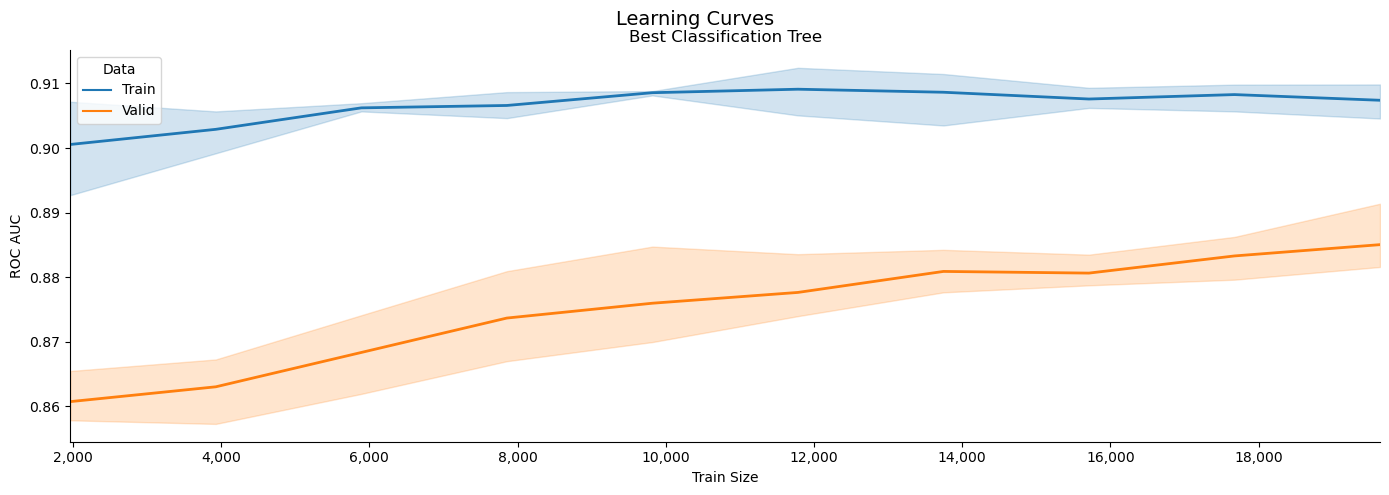

In [18]:
fig, axes = plt.subplots(ncols=1, figsize=(14, 5))
xmin, xmax = clf_lc_data['Train Size'].min(), clf_lc_data['Train Size'].max()
sns.lineplot(data=clf_lc_data,
             x='Train Size',
             y='ROC AUC',
             hue='Data',
             errorbar=('ci', 95),
             ax=axes,
             lw=2)
axes.set_title('Best Classification Tree')
axes.set_ylabel('ROC AUC')
axes.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

for i in [0, 1]:
    axes.tick_params(axis='both', which='major', labelsize=10)
    axes.tick_params(axis='both', which='minor', labelsize=8)
    axes.set_xlim(xmin, xmax)

fig.suptitle('Learning Curves', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

# Feature Importance

Decision trees can not only be visualized to inspect the decision path for a given feature, but also provide a summary measure of the contribution of each feature to the model fit to the training data. 

The feature importance captures how much the splits produced by the feature helped to optimize the model's metric used to evaluate the split quality, which in our case is the Gini Impurity index. 

A feature's importance is computed as the (normalized) total reduction of this metric and takes into account the number of samples affected by a split. Hence, features used earlier in the tree where the nodes tend to contain more samples typically are considered of higher importance.

In [19]:
top_n = 15
labels = ld.features.columns.str.replace('_', ' ').str.upper()
fi_clf = (pd.Series(grid_search.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

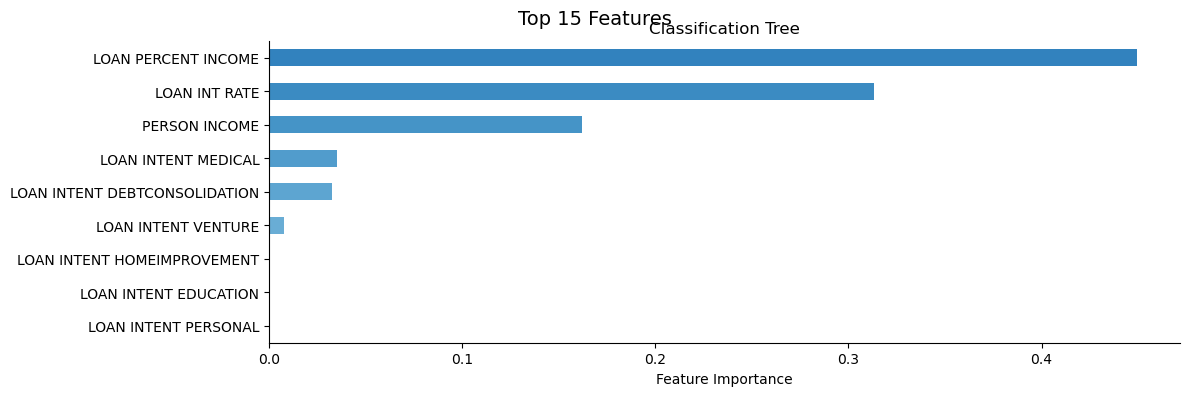

In [20]:
fig, axes= plt.subplots(ncols=1, figsize=(12,4), sharex=True)
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes, title='Classification Tree', color=color)
axes.set_xlabel('Feature Importance')
axes.set_xlabel('Feature Importance')
fig.suptitle(f'Top {top_n} Features', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)